<a href="https://colab.research.google.com/github/AdhirajChaddha/MNIST-Learning/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


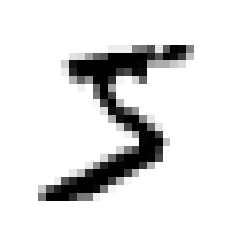

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

digit = X[0]
digit = digit.reshape(28, 28)

plt.imshow(digit, cmap='binary')
plt.axis("off")
plt.show()

In [4]:
y[0]

'5'

Lets start by crating a binary classifier that distinguishes between a 5 and not 5

In [0]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
# Lets create a vector that is true for all 5s and 
# false for all else
y_train_5 = y_train == '5'
print(y_train_5[:10])
y_test_5 = (y_test == '5')

[ True False False False False False False False False False]


In [7]:
# Lets then start by training a SGDClassifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [8]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [9]:
# This calssifier seems like a good one as ait achieves
# over 95% accuracy in all 3 validation folds. But, lets now
# create a classifier that classifies everything as false

from sklearn.base import BaseEstimator
import numpy as np

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    pass
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

never5 = Never5Classifier()
cross_val_score(never5, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [0]:
# The Classifier that returns none for all also have around
# 90% accuracy. hence we need a better measure, which is 
# where the confustion matrix comes handy

# For the confusion matrix, we need all the predictions our
# model made on teh test folds
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [0]:
# The above matrix shows that 53892 of the not 5s were 
# correctly classified as not 5(True Negative - TN), while 1891 
# we wrongly classified as 5 (flase positive - FP). 
# 687 5s were identitfied as not 5(False Negative - FN) and 
# 3530 5s were identified as 5(True Positive - TP)

# Two Interesting metrics to look at would be the precision
# and recall of the classifier

# precision = TP/(TP+FP) - how accurate are the +ve predictions
# recall = TP/(TP+FN) - ratio of +ve instances correctly detected

In [13]:
from sklearn.metrics import precision_score, recall_score
print("Precision is: ", precision_score(y_train_5, y_train_pred))
print("Recall is: ", recall_score(y_train_5, y_train_pred))

Precision is:  0.8370879772350012
Recall is:  0.6511713705958311


In [0]:
# This shows that our classifier is not as good as we thaught
# It only detects 65% of the 5s and when it says something is
# a 5 it is only correct 83% of the time. 

# Lets now look at the precsion recall curve of the classifier
# for this we need the decision scores and not the predictions
# as the precision depends on the decision score 
# (higher threshold would mean high precision as very high decsion)
# score required

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

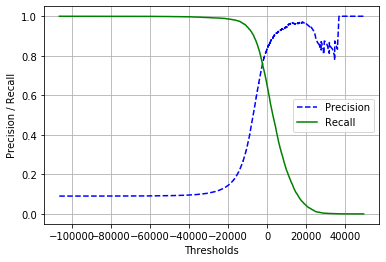

In [15]:
def plot_precision_recall_vs_threshold(precision, recall, threshold):
  plt.plot(threshold, precision[:-1], "b--", label="Precision")
  plt.plot(threshold, recall[:-1], "g-", label="Recall")
  plt.legend()
  plt.grid()
  plt.xlabel('Thresholds')
  plt.ylabel('Precision / Recall')
  plt.show()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

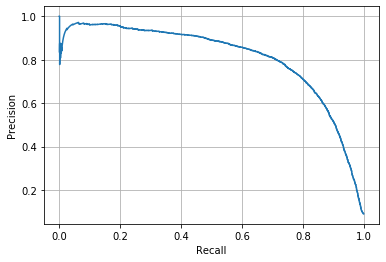

In [16]:
def plot_precision_vs_recall(precision, recall):
  plt.plot(recall, precision)
  plt.grid()
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.show()

plot_precision_vs_recall(precisions, recalls)

In [17]:
# The above curves show that to the best ballence is around
# 85% precision, 65% recall. altough one can get any precision
# by just increasing the threshold enough. For instance, if we
# want 90% precision
threshold_90 = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90)

print("Precision is: ", precision_score(y_train_5, y_train_pred_90))
print("Recall is: ", recall_score(y_train_5, y_train_pred_90))

Precision is:  0.9000345901072293
Recall is:  0.4799852425751706


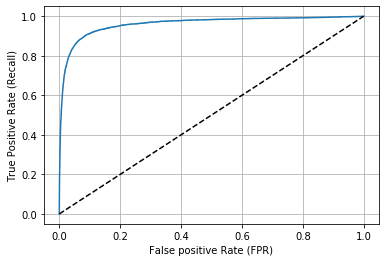

In [18]:
# Another good measuring charcteristic is the ROC curve. it 
# plots the true positive rate (TPR) (a.k.a. recall) vs the 
# false positive rate (FPR)

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, trp, label=None):
  plt.plot(fpr, tpr, label=label)
  plt.plot([0,1], [0,1], 'k--') # diagonal
  plt.grid()
  plt.xlabel('False positive Rate (FPR)')
  plt.ylabel('True Positive Rate (Recall)')

plot_roc_curve(fpr, tpr)
plt.show()

In [19]:
# The area under the ROC curve is a good measure of the 
# the performance of the classifier as a good one will
# have an area close to 1, while a bad one will have an
# area close to 0.5
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [20]:
# lets compare the ROC score of the SGD classifier with a
# random forest classifier.
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=11)
y_probs_forest = cross_val_predict(rf_clf, X_train, y_train_5, cv=3, method='predict_proba')

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
y_scores_forest = y_probs_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

In [22]:
print("ROC AUC is: ",roc_auc_score(y_train_5, y_scores_forest))

ROC AUC is:  0.9928336035153543


In [0]:
# This shows that the random forest is a much better
# Now lest create a multi class classfier

In [0]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([X_train[0]])

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
